# Image classification with neural networks

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

from sklearn.metrics import confusion_matrix

### Set up the dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Load the dataset
df = ImageFolder(root='STA380/data/EuroSAT_RGB', transform=transform)

# Split the data into a training set and a test set
train, test = random_split(df, [int(0.8 * len(df)), len(df) - int(0.8 * len(df))])

# Create dataloaders
trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False, num_workers=2)

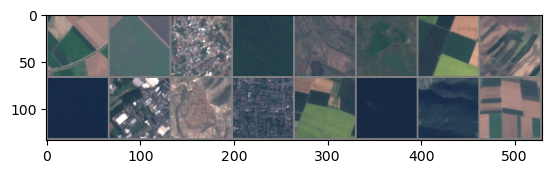

Labels: AnnualCrop AnnualCrop Residential Forest Pasture HerbaceousVegetation AnnualCrop PermanentCrop SeaLake Industrial HerbaceousVegetation Residential AnnualCrop SeaLake HerbaceousVegetation AnnualCrop


In [3]:
# Show some images and their labels
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:16]))

class_names = df.classes
print('Labels:', ' '.join('%s' % class_names[labels[j]] for j in range(16)))

### Build the model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64*30*30, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())



### Make the predictions and show some images with predicted labels

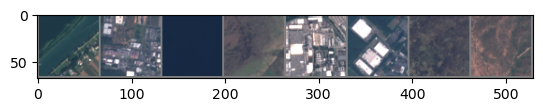

Predicted: HerbaceousVegetation HerbaceousVegetation HerbaceousVegetation HerbaceousVegetation HerbaceousVegetation HerbaceousVegetation HerbaceousVegetation HerbaceousVegetation
Epoch 1, Loss: 0.9834096422033197


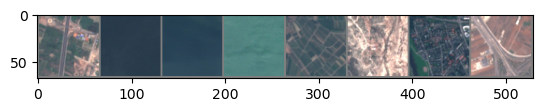

Predicted: PermanentCrop Forest SeaLake SeaLake PermanentCrop Residential Residential Highway
Epoch 2, Loss: 0.513612946770953


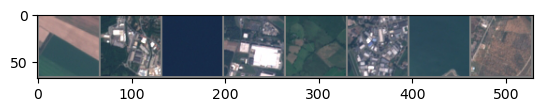

Predicted: AnnualCrop Industrial SeaLake Industrial Pasture Industrial SeaLake PermanentCrop
Epoch 3, Loss: 0.35056720524144597


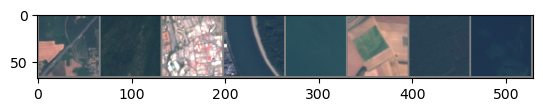

Predicted: Highway Forest Industrial River SeaLake AnnualCrop Forest SeaLake
Epoch 4, Loss: 0.2455167225258943


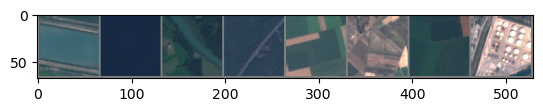

Predicted: River SeaLake Forest Highway AnnualCrop PermanentCrop Forest Industrial
Epoch 5, Loss: 0.14114301036712687
Finished Training


In [6]:
# Number of training epochs
num_epochs = 5

testiter = iter(testloader)
# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 10000 == 0:
            with torch.no_grad():
                # Show a sample of images from the test data and model's predictions
                test_images, test_labels = next(testiter)
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
                test_outputs = net(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)
                print('Predicted:', ' '.join('%s' % class_names[predicted[j]] for j in range(8)))

    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")

print('Finished Training')


### Calculate the accuracy

In [7]:
# Evaluate the model on the test set
correct = 0
total = 0

# Store the predictions and labels for confusion matrix
all_labels = []
all_preds = []

net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        test_outputs = net(images)
        _, predicted = torch.max(test_outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 83.50%


#### We gained an accuracy rate of 83.96%. This is suggesting that our model has done a good job predicting the labels of the images in the test set.

### Plot some test set images and their predicted labels

In [8]:
# Create an iterator from the testloader
sample_images = iter(testloader)

# Get the next batch of images and labels from the testloader
images, labels = next(sample_images)


### Generate a confusion matrix

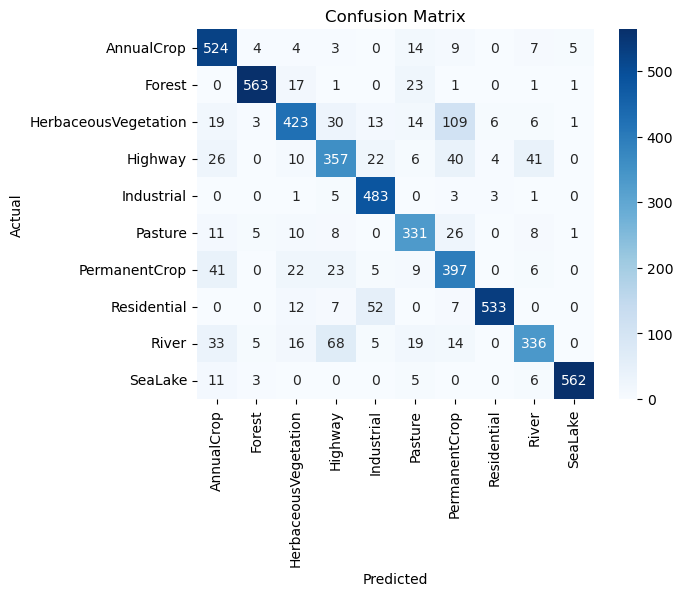

In [9]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_preds)

# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap = 'Blues', fmt='d', xticklabels=df.classes, yticklabels=df.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Our confusion matrix also indicates that we are correctly identifying the lables of a extremely large proportion of the images.